In [1]:
!pip install opencv-python

In [2]:
import os

print(os.listdir("/kaggle/input/datasetanomaly/Compfest"))

['Shooting', 'Burglary', 'Fighting', 'Normal_Videos_for_Event_Recognition']


In [3]:
dataset_path = "/kaggle/input/datasetanomaly/Compfest"

In [4]:
import pandas as pd
import cv2
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import albumentations as A

def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x//2) - (min_dim//2)
  start_y = (y//2) - (min_dim//2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

augmented_video = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussianBlur(p=0.2),
    A.ColorJitter(p=0.2)
])

def load_video(path, max_frames=16, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      # frame = frame[:, :, [2, 1, 0]]
      augmented = augmented_video(image=frame)
      frame = augmented["image"]  
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames)/255.0 

def augment_video(video):
  augmented_frames = []
  for frame in video:
      frame_uint8 = (frame*255).astype(np.uint8)
      augmented = augmented_video(image = frame_uint8)['image']
      augmented_frames.append(augmented.astype(np.float32)/255.0)
  return np.array(augmented_frames)  

def load_dataset(folder_path, max_frames=16, resize=(224, 224), augment_factor=2):
  X = []
  y = []
  class_names = sorted(os.listdir(folder_path))
  for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_folder):
      video_path = os.path.join(class_folder, file_name)
      frames = load_video(video_path, max_frames=max_frames, resize=resize)
      if len(frames) == max_frames:
        X.append(frames)
        y.append(idx)
        for _ in range(augment_factor - 1):
            augmented = augment_video(frames.copy())
            X.append(augmented)
            y.append(idx)
  X = np.array(X)
  y = to_categorical(np.array(y), num_classes=len(class_names))
  return X, y, class_names

2025-08-23 11:38:12.516639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755949092.726554      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755949092.787144      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
from sklearn.model_selection import train_test_split

X, y, class_names = load_dataset(dataset_path, max_frames = 16, resize=(224, 224), augment_factor=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print(y_train[:5])

X_train_final shape: (256, 16, 224, 224, 3)
y_train_final shape: (256, 4)
X_test shape: (80, 16, 224, 224, 3)
y_test shape: (80, 4)
X_val shape: (64, 16, 224, 224, 3)
y_val shape: (64, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [7]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3)
)
# base_model.trainable = False
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

inputs = layers.Input((16, 224, 224, 3))
x = layers.TimeDistributed(base_model)(inputs)
x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
x = layers.LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(4, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 7, 7, 2048) │    23,564,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16, 64)         │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,119,332 (92.01 MB)

 Trainable params: 8,434,212 (32.17 MB)

 Non-trainable params: 15,685,120 (59.83 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor = 'val_accuracy',patience=3, restore_best_weights=True)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    X_train_final, y_train_final,
    validation_data = (X_val, y_val),
    epochs = 20,
    batch_size = 4,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 645s 8s/step - accuracy: 0.3173 - loss: 1.9500 - val_accuracy: 0.4688 - val_loss: 1.7733
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 477s 7s/step - accuracy: 0.4726 - loss: 1.7881 - val_accuracy: 0.5938 - val_loss: 1.6073
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 476s 7s/step - accuracy: 0.6313 - loss: 1.5506 - val_accuracy: 0.5938 - val_loss: 1.5216
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 468s 7s/step - accuracy: 0.7649 - loss: 1.3723 - val_accuracy: 0.7500 - val_loss: 1.3441
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 468s 7s/step - accuracy: 0.8178 - loss: 1.1897 - val_accuracy: 0.7969 - val_loss: 1.2172
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 468s 7s/step - accuracy: 0.8289 - loss: 1.0933 - val_accuracy: 0.8438 - val_loss: 1.1312
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.8723 - loss: 0.9746 - val_accuracy: 0.7969 - val_loss: 1.0833
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 469s 7s/step - accuracy: 0.9000 - loss: 0.8784 - val_accuracy: 0.7188 - v

In [9]:
data_cat = os.listdir("/kaggle/input/datasetanomaly/Compfest")

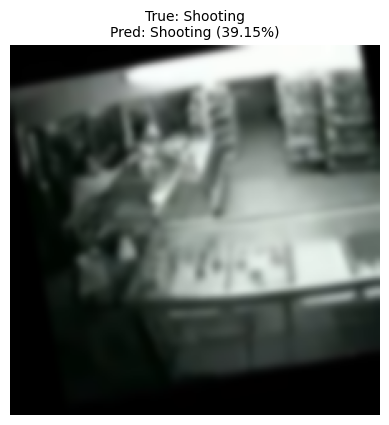

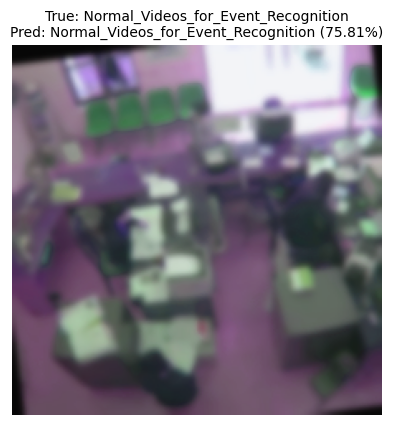

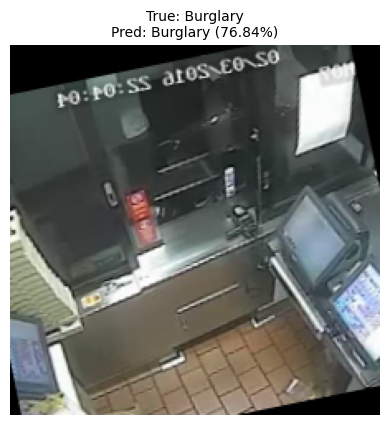

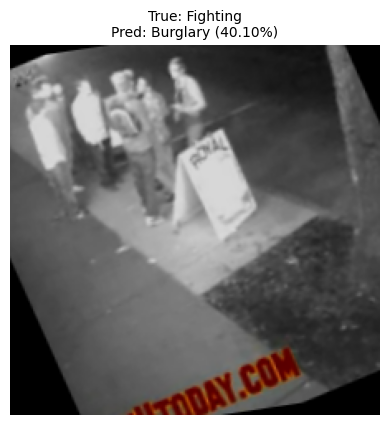

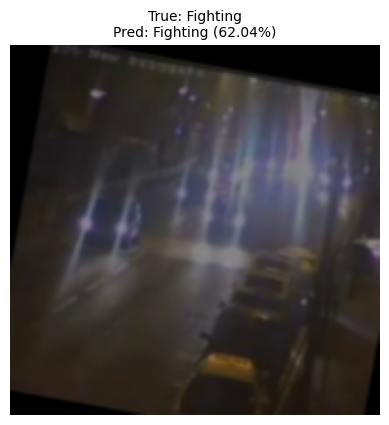

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(num_vid=5):
    idxs = np.random.choice(len(X_test), num_vid, replace=False)
    for idx in idxs:
        vid = X_test[idx]
        true_label_index = np.argmax(y_test[idx])
        true_label = class_names[true_label_index]
        
        prediction = model.predict(np.expand_dims(vid, axis=0), verbose=0)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_names[predicted_class_index]
        confidence = prediction[0][predicted_class_index]

        middle_frame = vid[len(vid)//2]
        plt.figure()
        plt.imshow((middle_frame*255).astype("uint8"))
        plt.title(
            f"True: {true_label}\nPred: {predicted_class} ({confidence*100:.2f}%)",
            fontsize=10
        )
        plt.axis('off')
        plt.show()
# def visualize_test_predictions(num_samples=5):
#     idxs = np.random.choice(len(X_test), num_samples, replace=False)  # pilih random sample dari test set
#     for idx in idxs:
#         video = X_test[idx]
#         true_label_index = np.argmax(y_test[idx])
#         true_label = class_names[true_label_index]
#         prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
#         predicted_class_index = np.argmax(prediction)
#         predicted_class = class_names[predicted_class_index]
#         confidence = prediction[0][predicted_class_index]

#         middle_frame = video[len(video)//2]

#         plt.figure(figsize=(4,4))
#         plt.imshow((middle_frame * 255).astype("uint8"))
#         plt.title(
#             f"True: {true_label}\nPred: {predicted_class} ({confidence*100:.2f}%)",
#             fontsize=10
#         )
#         plt.axis('off')
#         plt.show()

visualize_predictions()


3/3 ━━━━━━━━━━━━━━━━━━━━ 141s 31s/step


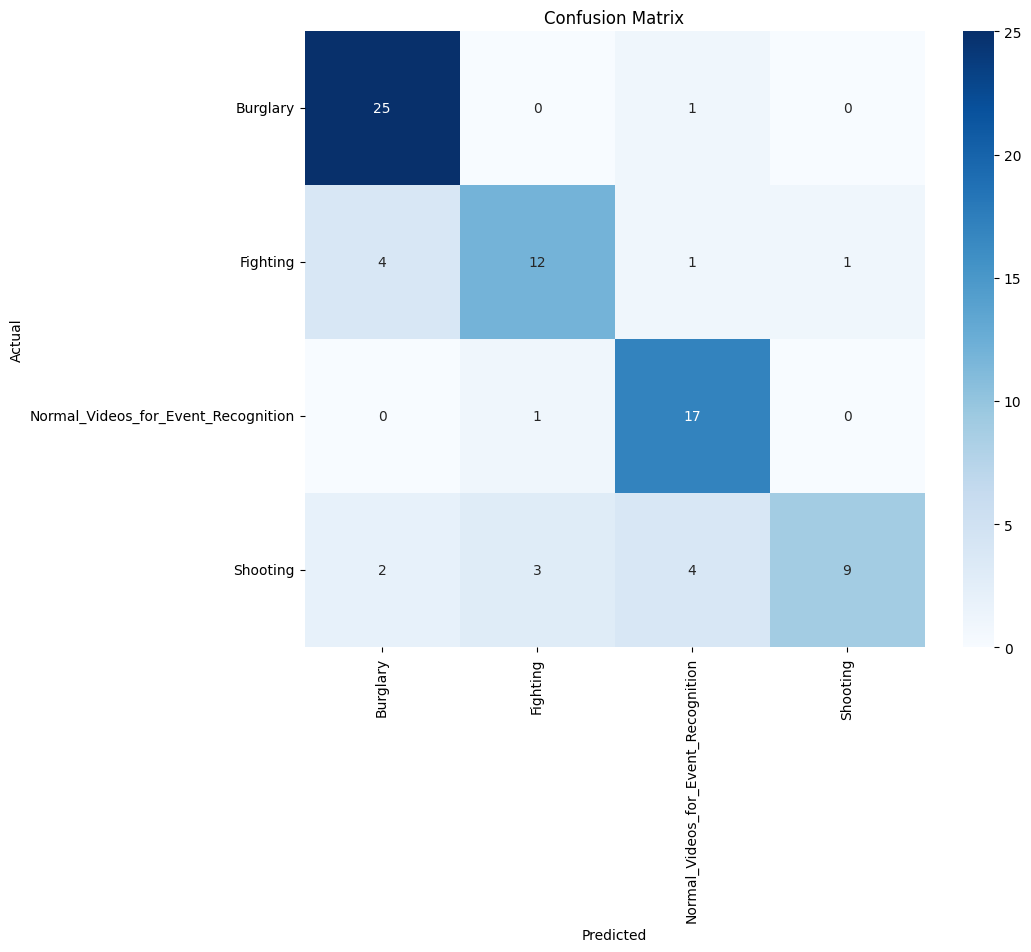

                                     precision    recall  f1-score   support

                           Burglary       0.81      0.96      0.88        26
                           Fighting       0.75      0.67      0.71        18
Normal_Videos_for_Event_Recognition       0.74      0.94      0.83        18
                           Shooting       0.90      0.50      0.64        18

                           accuracy                           0.79        80
                          macro avg       0.80      0.77      0.76        80
                       weighted avg       0.80      0.79      0.78        80



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Save model

model.save("model.h5")